In [ ]:
import pandas as pd
df_merged = pd.read_csv("df_merged.csv")


df_merged.head()


,month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,storey_mid,remaining_lease_years,...,Address Lat,Address Long,Nearest MRT Station,Nearest MRT Distance,Nearest Mall Name,Nearest Mall Distance,Nearest NPC,Nearest NPC Distance,cpi,resale_price_real
0,1/1/2017,ANG MO KIO,2 ROOM,44.0,Improved,1979.0,232000.0,2017.0,11.0,61.333333,...,1.362005,103.853880,ANG MO KIO MRT STATION (NS16),1.003997,AMK HUB,1.017286,Bishan Neighbourhood Police Centre,0.829747,85.102,274459.636671
1,1/1/2017,ANG MO KIO,3 ROOM,67.0,New Generation,1978.0,250000.0,2017.0,2.0,60.583333,...,1.370966,103.838202,MAYFLOWER MRT STATION (TE6),0.189875,AMK HUB,1.155700,Ang Mo Kio South Neighbourhood Police Centre,1.499927,85.102,295753.918827
2,1/1/2017,ANG MO KIO,3 ROOM,67.0,New Generation,1980.0,262000.0,2017.0,2.0,62.416667,...,1.380709,103.835368,LENTOR MRT STATION (TE5),0.535117,AMK HUB,1.925633,Ang Mo Kio North Neighbourhood Police Centre,1.182304,85.102,309950.106931
3,1/1/2017,ANG MO KIO,3 ROOM,68.0,New Generation,1980.0,265000.0,2017.0,5.0,62.000000,...,1.366201,103.857201,ANG MO KIO MRT STATION (NS16),0.945529,MYVILLAGE AT SERANGOON GARDEN,0.892904,Ang Mo Kio South Neighbourhood Police Centre,0.741873,85.102,313499.153956
4,1/1/2017,ANG MO KIO,3 ROOM,67.0,New Generation,1980.0,265000.0,2017.0,2.0,62.416667,...,1.381041,103.835132,LENTOR MRT STATION (TE5),0.501152,AMK HUB,1.969726,Ang Mo Kio North Neighbourhood Police Centre,1.192218,85.102,313499.153956


In [ ]:
merged_features = ['town', 'flat_type', 'flat_model', 'floor_area_sqm',
            'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year',
            'Address Lat', 'Address Long', 'Nearest MRT Station', 'Nearest MRT Distance', 'Nearest Mall Name',
            'Nearest Mall Distance', 'Nearest NPC', 'Nearest NPC Distance', 'cpi']
merged_target = 'resale_price_real'


X = df_merged[merged_features]
y = df_merged[merged_target]


In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

XGBoost

RMSE_XGBoost Regression= 34676.903041069294
R2 Score_XGBoost Regression= 0.9658367039040735


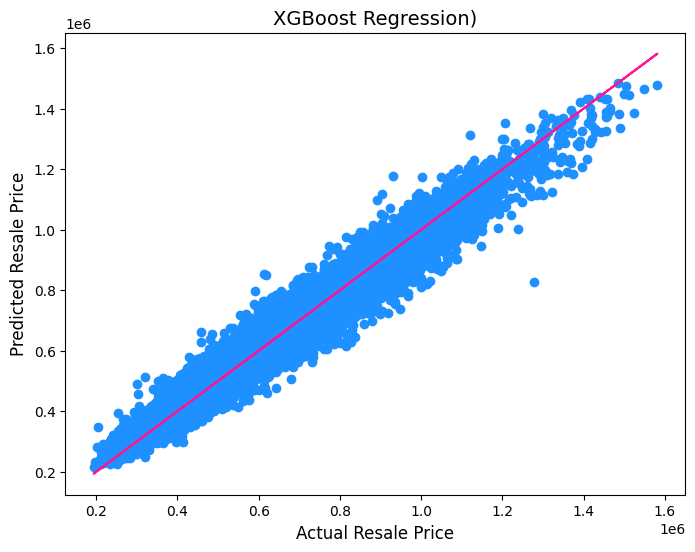

In [ ]:
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for data manipulation

# Define categorical and numerical features
categorical_features = ['town', 'flat_type', 'flat_model', 'Nearest MRT Station', 'Nearest Mall Name', 'Nearest NPC']
numerical_features = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year', 'Address Lat', 'Address Long', 'Nearest MRT Distance', 'Nearest Mall Distance', 'Nearest NPC Distance', 'cpi']

# Create a preprocessor for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)]) # sparse=False is important for XGBoost

# Create a pipeline with the preprocessor and XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgbr', xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                             colsample_bytree=1, max_depth=7))
])

# Fit the pipeline to the training data
xgb_pipeline.fit(X_train, y_train)

# Make predictions on the test data
prediction_xgbr = xgb_pipeline.predict(X_test)

# Impute NaN values in y_test (if any) with the mean before evaluation
# This prevents the ValueError
y_test = y_test.fillna(y_test.mean())

# Evaluate the model
print('RMSE_XGBoost Regression=', np.sqrt(metrics.mean_squared_error(y_test, prediction_xgbr)))
print('R2 Score_XGBoost Regression=', metrics.r2_score(y_test, prediction_xgbr))

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=prediction_xgbr, color='dodgerblue')
plt.plot(y_test, y_test, color='deeppink')
plt.xlabel('Actual Resale Price', fontsize=12)
plt.ylabel('Predicted Resale Price', fontsize=12)
plt.title('XGBoost Regression)', fontsize=14)
plt.show()

Correlation of features with Price

In [ ]:
# Convert 'month' to numerical representation (e.g., ordinal) before calculating correlation.
df_merged['month'] = pd.to_datetime(df_merged['month'])

# Now apply the toordinal function
df_merged['month_ordinal'] = df_merged['month'].apply(lambda date: date.toordinal())

# Select only numerical features for correlation calculation
numerical_features = df_merged.select_dtypes(include=['number']).columns
correlation = df_merged[numerical_features].drop(columns=['month_ordinal']).corr()  # Exclude month_ordinal if you don't want its correlation

# Now you can access and sort correlations with 'resale_price_real'
correlation['resale_price_real'].sort_values(ascending=False).drop('resale_price_real')

,resale_price_real
resale_price,0.981016
floor_area_sqm,0.627887
lease_commence_date,0.366593
storey_mid,0.365924
remaining_lease_years,0.337604
year,0.197811
cpi,0.186989
Address Long,0.103322
Nearest NPC Distance,-0.066381
Nearest MRT Distance,-0.109303


In [ ]:
corr = correlation['resale_price_real'].sort_values(ascending=False).drop('resale_price_real')

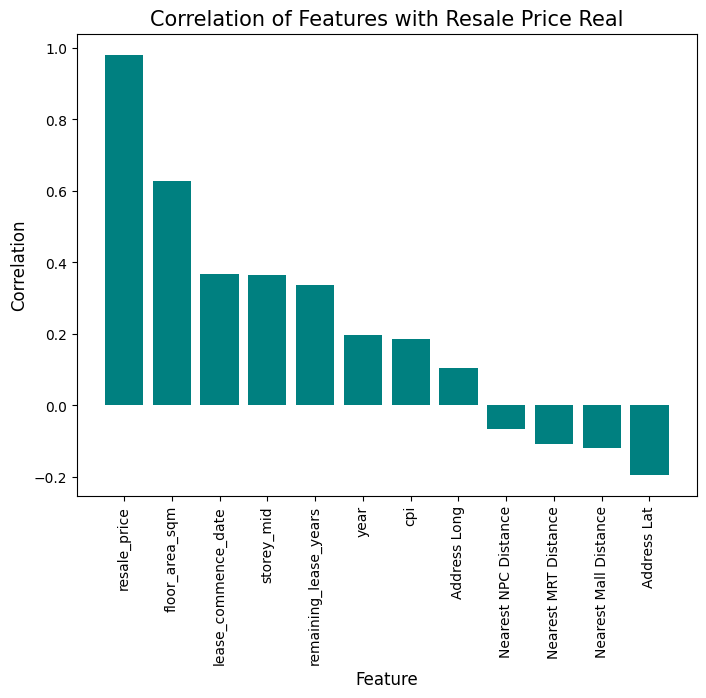

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(x=list(corr.index), height=list(corr.values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Resale Price Real', fontsize=15)
plt.show()

KNN + GridSearch

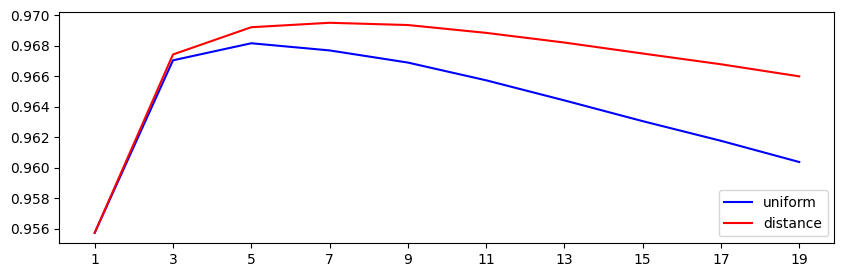

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Import necessary preprocessing tools
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Define categorical and numerical features for KNN
categorical_features = ['town', 'flat_type', 'flat_model', 'Nearest MRT Station', 'Nearest Mall Name', 'Nearest NPC']
numerical_features = ['floor_area_sqm', 'lease_commence_date', 'remaining_lease_years', 'storey_mid', 'year', 'Address Lat', 'Address Long', 'Nearest MRT Distance', 'Nearest Mall Distance', 'Nearest NPC Distance', 'cpi']

# Create a preprocessor for categorical and numerical features
# Include SimpleImputer to handle missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_features)])

# Create a pipeline with the preprocessor and KNN model
# Initialize with a default value for k
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5, weights='uniform'))  # Initialize with k=5
])

uniform = []
distance = []
r = range(1, 21, 2)

for k in r:

    # Euclidan, 'straight' distance
    # Instead of fitting the model directly, use the pipeline
    knn_pipeline.set_params(knn__n_neighbors=k, knn__weights='uniform')  # Update pipeline parameters
    knn_pipeline.fit(X_train, y_train)  # Fit the pipeline
    uniform.append(knn_pipeline.score(X_test, y_test))


    # Distance is inversely proportional (to lessen the weight of outliers)
    knn_pipeline.set_params(knn__n_neighbors=k, knn__weights='distance')  # Update pipeline parameters
    knn_pipeline.fit(X_train, y_train)  # Fit the pipeline
    distance.append(knn_pipeline.score(X_test, y_test))

uniform = np.array(uniform)
distance = np.array(distance)

plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi'] = 100  # 200 e.g. is really fine, but slower
plt.plot(r, uniform, label='uniform', color='blue')
plt.plot(r, distance, label='distance', color='red')
plt.legend()
plt.gca().set_xticks(r)
plt.show()

In [ ]:
pd.DataFrame({"k" : r, "uniform" : uniform, "distance" : distance})


,k,uniform,distance
0,1,0.955724,0.955724
1,3,0.967044,0.967427
2,5,0.968163,0.969216
3,7,0.967693,0.969507
4,9,0.966896,0.969360
5,11,0.965732,0.968845
6,13,0.964412,0.968210
7,15,0.963051,0.967490
8,17,0.961760,0.966784
9,19,0.960369,0.965991


In [ ]:
params = {'n_neighbors':range(1,21,2),'weights':['uniform','distance']}


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
# Include parameters for the KNN model within the pipeline
params = {
    'knn__n_neighbors': range(1, 21, 2),  # Update parameter names to include 'knn__'
    'knn__weights': ['uniform', 'distance']
}

# Use the knn_pipeline (which includes preprocessing) within GridSearchCV
model = GridSearchCV(knn_pipeline, params, cv=5)  # Use the pipeline here

# Now, the preprocessing steps will be applied during the fit process
model.fit(X_train, y_train)
model.best_params_

{'knn__n_neighbors': 7, 'knn__weights': 'distance'}

In [ ]:
model.score(X_test, y_test)

0.9695073099302559